In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#reading from ratings file
ratings = pd.read_csv("./ml-100k/u.data",sep="\t",names = ["user_id", "item_id" , "ratings", "timestamp"])

#reading from item file for movies information
movies = pd.read_csv("./ml-100k/u.item",sep="|",names = ["movie_id", "movie_title",\
            "release date", "video release date", "IMDb URL", "unknown", "Action",\
            "Adventure","Animation", "Children's", "Comedy", "Crime", "Documentary",\
            "Drama","Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",\
            "Romance","Sci-Fi", "Thriller", "War", "Western"], encoding='latin-1')

n_users = ratings.user_id.unique().shape[0]
n_items = ratings.item_id.unique().shape[0]
print(n_users, 'users', n_items, 'movies')

943 users 1682 movies


In [2]:
def cosine_similarity(index_count, mat):
    similar=np.eye(index_count,index_count)
    for i in range(0,index_count):
        #avoid multiple time same computations
        user1 = np.sqrt(np.sum(np.square(mat[i])))
        # dont compute if it is a new user
        if user1 == 0:
            continue
        for j in range(i + 1,index_count):#columns for similarity matrix
            # dont compute if it is a new user
            user2 = np.sqrt(np.sum(np.square(mat[j])))
            if user2 == 0:
                continue                        
            compare=np.divide(np.sum(np.multiply(mat[i],mat[j])),np.multiply(user1, user2))
            similar[i,j]=compare
            similar[j,i]=compare
    return similar


def prediction_matrix(index_count, columns_cnt, mat, similar, rating_matrix, threshold):
    similar = np.where(similar >= threshold, similar, 0)
    for i in range(index_count):
        for j in range(columns_cnt):
            if(mat[i][j] == 0):
                
                # formula for denominator only rate the ones that the other user rated
                total = np.sum(np.multiply(similar[:,i] , rating_matrix[:,j]))
                if total == 0:
                    continue
                #numerator sum of product of similarity and item rating values divide by total
                mat[i][j] = np.divide(np.sum(np.multiply(similar[:, i], mat[:, j])),total)
                rating_matrix[i][j] = 1
    return mat

In [3]:
#user-user collaborative filtering with centred cosine similarity
tab_user = ratings.pivot_table(columns = ["item_id"] , index = ["user_id"], values = "ratings")
user_A = ((tab_user.T - tab_user.T.mean()).T)
user_A = user_A.fillna(0)
user_A = np.array(user_A)

similar_user = cosine_similarity(user_A.shape[0], user_A)

index_cnt_user=user_A.shape[0]
columns_cnt_user=user_A.shape[1]

rating_matrix_user = user_A
rating_matrix_user = np.where(rating_matrix_user == 0, rating_matrix_user, 1)

user_B = user_A
user_B = prediction_matrix(index_cnt_user, columns_cnt_user, user_B, similar_user, rating_matrix_user, 0)

user_id = 117
recommendations = []
lowest = -float('Inf')

for i in range(len(user_B[user_id])):
    if len(recommendations) < 10:
        recommendations.append((user_B[user_id][i],i))
        recommendations.sort(key=lambda x: x[0],reverse = True)
        lowest = recommendations[-1][0]
    elif(user_B[user_id][i] > lowest):
        recommendations.append((user_B[user_id][i],i))
        recommendations.sort(key=lambda x: x[0],reverse = True)
        recommendations = recommendations[:10]
        lowest = recommendations[-1][0]

print('Top 10 Recommended Movies for userId:',user_id)
for i in range(len(recommendations)):
    print(i + 1,movies.loc[recommendations[i][1]].movie_title)

Top 10 Recommended Movies for userId: 117
1 Great Day in Harlem, A (1994)
2 Aiqing wansui (1994)
3 Saint of Fort Washington, The (1993)
4 Someone Else's America (1995)
5 Santa with Muscles (1996)
6 Entertaining Angels: The Dorothy Day Story (1996)
7 Some Mother's Son (1996)
8 Pather Panchali (1955)
9 Anna (1996)
10 Faust (1994)


In [4]:
#item-item collaborative filtering with centred cosine similarity
tab_item = ratings.pivot_table(columns = ["user_id"] , index = ["item_id"], values = "ratings")
Item_A = ((tab_item.T - tab_item.T.mean()).T)
#Item_A = tab_item
Item_A=Item_A.fillna(0)
Item_A = np.array(Item_A)

similar_item = cosine_similarity(Item_A.shape[0], Item_A)

index_cnt_item=Item_A.shape[0]
columns_cnt_item=Item_A.shape[1]

rating_matrix_item = Item_A
rating_matrix_item = np.where(rating_matrix_item == 0, rating_matrix_item, 1)

item_B = Item_A
item_B = prediction_matrix(index_cnt_item, columns_cnt_item, item_B, similar_item, rating_matrix_item, 0)

user_id = 117
recommendations = []
lowest = -float('Inf')

for i in range(len(item_B[:,user_id])):
    if len(recommendations) < 10:
        recommendations.append((item_B[:,user_id][i],i))
        recommendations.sort(key=lambda x: x[0],reverse = True)
        lowest = recommendations[-1][0]       
    elif(item_B[:,user_id][i] > lowest):
        recommendations.append((item_B[:,user_id][i],i))
        recommendations.sort(key=lambda x: x[0],reverse = True)
        recommendations = recommendations[:10]
        lowest = recommendations[-1][0]

print('Top 10 Recommended Movies for userId:',user_id)
for i in range(len(recommendations)):
    print(i + 1,movies.loc[recommendations[i][1]].movie_title)

Top 10 Recommended Movies for userId: 117
1 Lord of Illusions (1995)
2 Serial Mom (1994)
3 Prophecy, The (1995)
4 Natural Born Killers (1994)
5 Naked (1993)
6 Joe's Apartment (1996)
7 Young Poisoner's Handbook, The (1995)
8 Freeway (1996)
9 Army of Darkness (1993)
10 Scream (1996)


In [5]:
#5 fold cross validation metrics
train_data_sets = ['./ml-100k/u1.base','./ml-100k/u2.base','./ml-100k/u3.base','./ml-100k/u4.base','./ml-100k/u5.base']
test_data_sets = ['./ml-100k/u1.test','./ml-100k/u2.test','./ml-100k/u3.test','./ml-100k/u4.test','./ml-100k/u5.test']

names = ['user_id', 'item_id', 'ratings', 'timestamp']

def rmse(y_pred, y):
    y_pred = y_pred[y.nonzero()].flatten()
    y = y[y.nonzero()].flatten()
    return np.sqrt(np.mean((y - y_pred)**2))

In [6]:
#user-user 5 fold cross validation metrics
rmse_list_user = []
ratings_pivot_user = ratings.pivot_table(columns = ['item_id'] , index = ['user_id'], values = 'ratings')

for file_index in range(len(train_data_sets)):
    train = np.zeros(ratings_pivot_user.shape)
    data_from_file = pd.read_csv(train_data_sets[file_index], sep='\t', names = names)
    
    for i in range(len(data_from_file)):
        train[data_from_file.user_id[i] - 1, data_from_file.item_id[i] - 1] = data_from_file.ratings[i]
    
    train = np.nan_to_num(train)
    #print('train:',train.shape)
    
    similarity_user = cosine_similarity(train.shape[0], train)

    #print('similarity:', similarity_user.shape)
    
    index_cnt_user = train.shape[0]
    columns_cnt_user = train.shape[1]
    
    rating_matrix_user = train.copy()
    rating_matrix_user = np.where(rating_matrix_user == 0, rating_matrix_user, 1)
    
    user_B = train.copy()
    user_B = prediction_matrix(index_cnt_user, columns_cnt_user, user_B, similarity_user, rating_matrix_user, 0)
    
    #print('prediction_matrix:', user_B.shape)
    test = pd.read_csv(test_data_sets[file_index], sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_user.shape)
    for k in range(len(test)):
        test_modified[test.user_id[k] - 1, test.item_id[k] - 1] = test.ratings[k]
    test_modified = np.nan_to_num(test_modified)

    #print(train_data_sets[file_index], train.shape)
    
    #print(test_modified.shape)
    rmse_val = rmse(user_B, test_modified)
    #print(rmse_val)
    rmse_list_user.append(rmse_val)
print('RMSE metrics for 5 Fold Cross Validations (User-User) with Cosine similarity measure:')
print(rmse_list_user)
    

RMSE metrics for 5 Fold Cross Validations (User-User) with Cosine similarity measure:
[1.0324212788641327, 1.0279842679864137, 1.0219558174819756, 1.0173633049699564, 1.0258947145181945]


In [7]:
#user-user 5 fold cross validation metrics with centred cosine (no bias) 
rmse_list_user2 = []
ratings_pivot_user = ratings.pivot_table(columns = ['item_id'] , index = ['user_id'], values = 'ratings')

for file_index in range(len(train_data_sets)):
    train = np.zeros(ratings_pivot_user.shape)
    data_from_file = pd.read_csv(train_data_sets[file_index], sep='\t', names = names)
    
    for i in range(len(data_from_file)):
        train[data_from_file.user_id[i] - 1, data_from_file.item_id[i] - 1] = data_from_file.ratings[i]
    train = (train.T - train.T.mean()).T
    train = np.nan_to_num(train)
    #print('train:',train.shape)
    
    similarity_user = cosine_similarity(train.shape[0], train)

    #print('similarity:', similarity_user.shape)
    
    index_cnt_user = train.shape[0]
    columns_cnt_user = train.shape[1]
    
    rating_matrix_user = train.copy()
    rating_matrix_user = np.where(rating_matrix_user == 0, rating_matrix_user, 1)
    
    user_B = train.copy()
    user_B = prediction_matrix(index_cnt_user, columns_cnt_user, user_B, similarity_user, rating_matrix_user, 0)
    
    #print('prediction_matrix:', user_B.shape)
    test = pd.read_csv(test_data_sets[file_index], sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_user.shape)
    for k in range(len(test)):
        test_modified[test.user_id[k] - 1, test.item_id[k] - 1] = test.ratings[k]
    test_modified = (test_modified.T - test_modified.T.mean()).T
    test_modified = np.nan_to_num(test_modified)

    #print(train_data_sets[file_index], train.shape)
    
    #print(test_modified.shape)
    rmse_val = rmse(user_B, test_modified)
    #print(rmse_val)
    rmse_list_user2.append(rmse_val)
print('RMSE metrics for 5 Fold Cross Validations (User-User) with Centred Cosine similarity measure:')
print(rmse_list_user2)


RMSE metrics for 5 Fold Cross Validations (User-User) with Centred Cosine similarity measure:
[0.9206820950105542, 0.9207096574914108, 0.9206420488507733, 0.920630696221275, 0.9206354578266757]


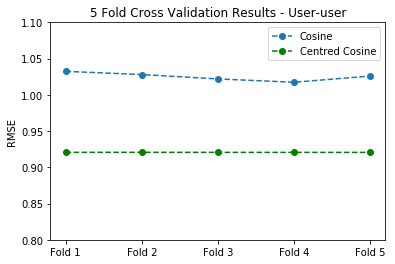

In [9]:
fold_list =['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5']
import matplotlib.pyplot as plt 
plt.plot(fold_list, rmse_list_user, label = 'Cosine',linestyle='--', marker='o')
plt.plot(fold_list, rmse_list_user2, label = 'Centred Cosine', c='g',linestyle='--', marker='o')
plt.ylabel('RMSE') 
plt.ylim(0.8, 1.1)
plt.legend()
plt.title('5 Fold Cross Validation Results - User-user')

plt.show()

In [10]:
#item-item 5 fold cross validation metrics

rmse_list_item = []
ratings_pivot_item = ratings.pivot_table(columns = ['user_id'] , index = ['item_id'], values = 'ratings')

for file_index in range(len(train_data_sets)):
    train = np.zeros(ratings_pivot_item.shape)
    data_from_file = pd.read_csv(train_data_sets[file_index], sep='\t', names = names)
    
    for i in range(len(data_from_file)):
        train[data_from_file.item_id[i] - 1, data_from_file.user_id[i] - 1] = data_from_file.ratings[i]
    
    train = np.nan_to_num(train)
    #print('train:',train.shape)
    
    similarity_item = cosine_similarity(train.shape[0], train)

    #print('similarity:', similarity_user.shape)
    
    index_cnt_item = train.shape[0]
    columns_cnt_item = train.shape[1]
    
    rating_matrix_item = train.copy()
    rating_matrix_item = np.where(rating_matrix_item == 0, rating_matrix_item, 1)
    
    item_B = train.copy()
    item_B = prediction_matrix(index_cnt_item, columns_cnt_item, item_B, similarity_item, rating_matrix_item, 0)
    
    #print('prediction_matrix:', user_B.shape)
    test = pd.read_csv(test_data_sets[file_index], sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_item.shape)
    for k in range(len(test)):
        test_modified[test.item_id[k] - 1, test.user_id[k] - 1] = test.ratings[k]
    test_modified = np.nan_to_num(test_modified)

    #print(train_data_sets[file_index], train.shape)
    
    #print(test_modified.shape)
    rmse_val = rmse(item_B, test_modified)
    #print(rmse_val)
    rmse_list_item.append(rmse_val)
print('RMSE metrics for 5 Fold Cross Validations (Item-Item) with Cosine similarity measure:')
print(rmse_list_item)

RMSE metrics for 5 Fold Cross Validations (Item-Item) with Cosine similarity measure:
[1.060447875134003, 1.0408761786986704, 1.0280772580170938, 1.0325944951020634, 1.0384011483363973]


In [11]:
#item-item 5 fold cross validation metrics with centred cosine
rmse_list_item2 = []
ratings_pivot_item = ratings.pivot_table(columns = ['user_id'] , index = ['item_id'], values = 'ratings')

for file_index in range(len(train_data_sets)):
    train = np.zeros(ratings_pivot_item.shape)
    data_from_file = pd.read_csv(train_data_sets[file_index], sep='\t', names = names)
    
    for i in range(len(data_from_file)):
        train[data_from_file.item_id[i] - 1, data_from_file.user_id[i] - 1] = data_from_file.ratings[i]
    train = (train.T - train.T.mean()).T
    train = np.nan_to_num(train)
    #print('train:',train.shape)
    
    similarity_item = cosine_similarity(train.shape[0], train)

    #print('similarity:', similarity_user.shape)
    
    index_cnt_item = train.shape[0]
    columns_cnt_item = train.shape[1]
    
    rating_matrix_item = train.copy()
    rating_matrix_item = np.where(rating_matrix_item == 0, rating_matrix_item, 1)
    
    item_B = train.copy()
    item_B = prediction_matrix(index_cnt_item, columns_cnt_item, item_B, similarity_item, rating_matrix_item, 0)
    
    #print('prediction_matrix:', user_B.shape)
    test = pd.read_csv(test_data_sets[file_index], sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_item.shape)
    for k in range(len(test)):
        test_modified[test.item_id[k] - 1, test.user_id[k] - 1] = test.ratings[k]
    test_modified = (test_modified.T - test_modified.T.mean()).T
    test_modified = np.nan_to_num(test_modified)

    #print(train_data_sets[file_index], train.shape)
    
    #print(test_modified.shape)
    rmse_val = rmse(item_B, test_modified)
    #print(rmse_val)
    rmse_list_item2.append(rmse_val)
print('RMSE metrics for 5 Fold Cross Validations (Item-Item) with Centred Cosine similarity measure:')
print(rmse_list_item2)

RMSE metrics for 5 Fold Cross Validations (Item-Item) with Centred Cosine similarity measure:
[0.9206820950105541, 0.9207096574914113, 0.9206420488507728, 0.9206306962212751, 0.9206354578266754]


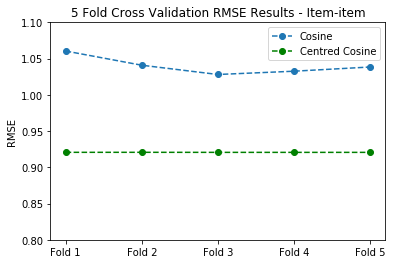

In [12]:
fold_list =['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5']

import matplotlib.pyplot as plt 
plt.plot(fold_list, rmse_list_item, label = 'Cosine',linestyle='--', marker='o')
plt.plot(fold_list, rmse_list_item2, label = 'Centred Cosine', c='g',linestyle='--', marker='o')
plt.ylabel('RMSE') 
plt.ylim(0.8, 1.1)
plt.legend()
plt.title('5 Fold Cross Validation RMSE Results - Item-item')
plt.show()

In [13]:
#user-user rmse with change in the percent of similar users considered for prediction - centred cosine
rmse_list_user_k_selection = []
train = np.zeros(ratings_pivot_user.shape)

thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in thres:
    ratingsu1 = pd.read_csv("./ml-100k/u1.base",sep="\t",names = names)
    for i in range(len(ratingsu1)):
        train[ratingsu1.user_id[i] - 1, ratingsu1.item_id[i] - 1] = ratingsu1.ratings[i]
    train = (train.T - train.T.mean()).T #centred cosine
    train = np.nan_to_num(train)

    user_A_u1 = train.copy()

    similar_user_u1 = cosine_similarity(user_A_u1.shape[0], user_A_u1)

    index_cnt_user_u1=user_A_u1.shape[0]
    columns_cnt_user_u1=user_A_u1.shape[1]
    
    rating_matrix_user_u1 = train.copy()
    rating_matrix_user_u1 = np.where(rating_matrix_user_u1 == 0, rating_matrix_user_u1, 1)

    #has the rating for the movies
    user_B_u1 = train.copy()
    user_B_u1 = prediction_matrix(index_cnt_user_u1, columns_cnt_user_u1, user_B_u1, similar_user_u1, rating_matrix_user_u1,i)

    test = pd.read_csv("./ml-100k/u1.test", sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_user.shape)
    for k in range(len(test)):
        test_modified[test.user_id[k] - 1, test.item_id[k] - 1] = test.ratings[k]
    test_modified = (test_modified.T - test_modified.T.mean()).T
    test_modified = np.nan_to_num(test_modified)

    rmse_val = rmse(user_B_u1, test_modified)
    #print(rmse_val)
    rmse_list_user_k_selection.append(rmse_val)
print('RMSE measure for different percentage of similar users considered for Prediction')
print(rmse_list_user_k_selection)

RMSE measure for different percentage of similar users considered for Prediction
[0.9206820950105542, 0.9540010310965048, 0.9556928215357815, 0.9557781785880638, 0.95578248384213, 0.9557827009879355, 0.9557827119401965, 0.9557827124925989, 0.9557827125204607, 0.9557827125218663, 0.955782712521937]


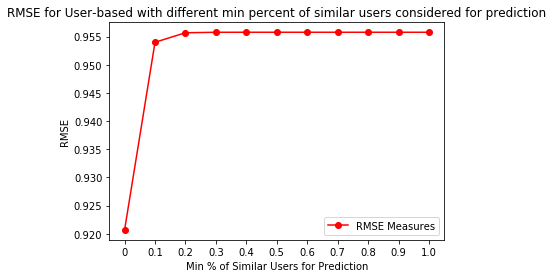

In [14]:
import matplotlib.pyplot as plt
thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
#rmse_list_user_k_selection = [0.9206820950105542, 0.9540010310965048, 0.9556928215357815, 0.9557781785880638, 0.95578248384213, 0.9557827009879355, 0.9557827119401965, 0.9557827124925989, 0.9557827125204607, 0.9557827125218663, 0.955782712521937]
xi = [i for i in range(0, len(thres))]
plt.plot(xi, rmse_list_user_k_selection, label = 'RMSE Measures', marker='o', c='r')
plt.xlabel('Min % of Similar Users for Prediction')
plt.ylabel('RMSE')
plt.xticks(xi, thres)
plt.legend()
plt.title('RMSE for User-based with different min percent of similar users considered for prediction')
plt.show()

In [15]:
#user-user accuracy with change in the percent of similar users considered for prediction
train = np.zeros(ratings_pivot_user.shape)
accuracy_list_user_k_selection = []

thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
best_accuracy_user = 0
hyper_user = 0
hyper_parameter = 0
for i in thres:
    ratingsu1 = pd.read_csv("./ml-100k/u1.base",sep="\t",names = names)
    for j in range(len(ratingsu1)):
        train[ratingsu1.user_id[j] - 1, ratingsu1.item_id[j] - 1] = ratingsu1.ratings[j]

    train = np.nan_to_num(train)

    user_A_u1 = train.copy()

    similar_user_u1 = cosine_similarity(user_A_u1.shape[0], user_A_u1)

    index_cnt_user_u1=user_A_u1.shape[0]
    columns_cnt_user_u1=user_A_u1.shape[1]
    
    rating_matrix_user_u1 = train.copy()
    rating_matrix_user_u1 = np.where(rating_matrix_user_u1 == 0, rating_matrix_user_u1, 1)

    #has the rating for the movies
    user_B_u1 = train.copy()
    user_B_u1 = prediction_matrix(index_cnt_user_u1, columns_cnt_user_u1, user_B_u1, similar_user_u1, rating_matrix_user_u1,i)

    test = pd.read_csv("./ml-100k/u1.test", sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_user.shape)
    for k in range(len(test)):
        test_modified[test.user_id[k] - 1, test.item_id[k] - 1] = test.ratings[k]

    test_modified = np.nan_to_num(test_modified)

    U = 0
    for k in range(len(test)):
        if round(user_B_u1[test.user_id[k]][test.item_id[k]]) == test.ratings[k]:
            U +=1
    accuracy_user = U/len(test)
    #print("accuracy of user-user for ",i,"= ", U/len(test), U)
    accuracy_list_user_k_selection.append(accuracy_user)
print('Accuracy measure for different percentage of similar users considered for Prediction')    
print(accuracy_list_user_k_selection)

Accuracy measure for different percentage of similar users considered for Prediction
[0.3036, 0.3028, 0.28785, 0.17995, 0.065, 0.02485, 0.0203, 0.0203, 0.0203, 0.0203, 0.0203]


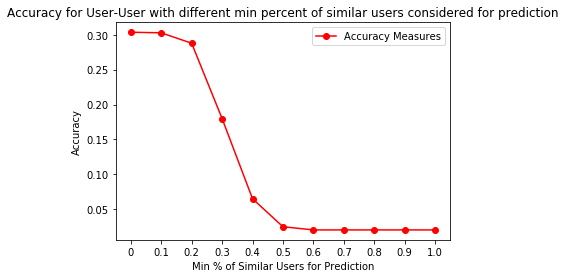

In [16]:
import matplotlib.pyplot as plt
thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
#accuracy_list_user_k_selection = [0.9206820950105542, 0.9540010310965048, 0.9556928215357815, 0.9557781785880638, 0.95578248384213, 0.9557827009879355, 0.9557827119401965, 0.9557827124925989, 0.9557827125204607, 0.9557827125218663, 0.955782712521937]
xi = [i for i in range(0, len(thres))]
plt.plot(xi, accuracy_list_user_k_selection, label = 'Accuracy Measures', marker='o', c='r')
plt.xlabel('Min % of Similar Users for Prediction')
plt.ylabel('Accuracy')
plt.xticks(xi, thres)
plt.legend()
plt.title('Accuracy for User-User with different min percent of similar users considered for prediction')
plt.show()

In [17]:
#item-item rmse with change in the percent of similar users considered for prediction - centred cosine
rmse_list_item_k_selection = []
train = np.zeros(ratings_pivot_item.shape)

thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
best_accuracy_user = 0
best_accuracy_item = 0
hyper_user = 0
hyper_parameter = 0
for i in thres:
    ratingsu1 = pd.read_csv("./ml-100k/u1.base",sep="\t",names = names)
    for j in range(len(ratingsu1)):
        train[ratingsu1.item_id[j] - 1, ratingsu1.user_id[j] - 1] = ratingsu1.ratings[j]
    train = (train.T - train.T.mean()).T #centred cosine
    train = np.nan_to_num(train)

    item_A_u1 = train.copy()

    similar_item_u1 = cosine_similarity(item_A_u1.shape[0], item_A_u1)

    index_cnt_item_u1 = item_A_u1.shape[0]
    columns_cnt_item_u1 = item_A_u1.shape[1]
    
    rating_matrix_item_u1 = train.copy()
    rating_matrix_item_u1 = np.where(rating_matrix_item_u1 == 0, rating_matrix_item_u1, 1)

    #has the rating for the movies
    item_B_u1 = train.copy()
    item_B_u1 = prediction_matrix(index_cnt_item_u1, columns_cnt_item_u1, item_B_u1, similar_item_u1, rating_matrix_item_u1,i)

    test = pd.read_csv("./ml-100k/u1.test", sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_item.shape)
    for k in range(len(test)):
        test_modified[test.item_id[k] - 1, test.user_id[k] - 1] = test.ratings[k]
    test_modified = (test_modified.T - test_modified.T.mean()).T
    test_modified = np.nan_to_num(test_modified)

    rmse_val = rmse(item_B_u1, test_modified)
    #print(rmse_val)
    rmse_list_item_k_selection.append(rmse_val)
print('RMSE measure for different percentage of similar users considered for Prediction')  
print(rmse_list_item_k_selection)

RMSE measure for different percentage of similar users considered for Prediction
[0.9206820950105541, 0.9540010310965047, 0.9556928215357815, 0.9557781785880638, 0.95578248384213, 0.9557827009879352, 0.9557827119401963, 0.9557827124925997, 0.9557827125204611, 0.9557827125218662, 0.9557827125219371]


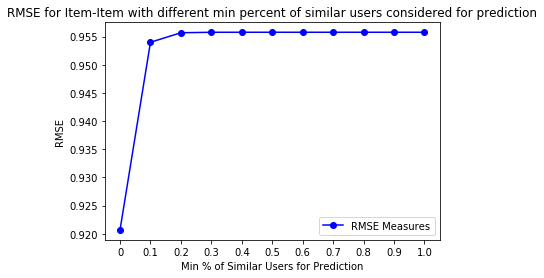

In [18]:
import matplotlib.pyplot as plt
thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
#rmse_list_item_k_selection = [0.9206820950105542, 0.9540010310965048, 0.9556928215357815, 0.9557781785880638, 0.95578248384213, 0.9557827009879355, 0.9557827119401965, 0.9557827124925989, 0.9557827125204607, 0.9557827125218663, 0.955782712521937]
xi = [i for i in range(0, len(thres))]
plt.plot(xi, rmse_list_item_k_selection, label = 'RMSE Measures', marker='o', c='b')
plt.xlabel('Min % of Similar Users for Prediction')
plt.ylabel('RMSE')
plt.xticks(xi, thres)
plt.legend()
plt.title('RMSE for Item-Item with different min percent of similar users considered for prediction')
plt.show()

In [20]:
#item-item accuracy with change in the percent of similar users considered for prediction - cosine
accuracy_list_item_k_selection = []
train = np.zeros(ratings_pivot_item.shape)

thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
best_accuracy_user = 0
best_accuracy_item = 0
hyper_user = 0
hyper_parameter = 0
for i in thres:
    ratingsu1 = pd.read_csv("./ml-100k/u1.base",sep="\t",names = names)
    for j in range(len(ratingsu1)):
        train[ratingsu1.item_id[j] - 1, ratingsu1.user_id[j] - 1] = ratingsu1.ratings[j]
    train = np.nan_to_num(train)

    item_A_u1 = train.copy()

    similar_item_u1 = cosine_similarity(item_A_u1.shape[0], item_A_u1)

    index_cnt_item_u1 = item_A_u1.shape[0]
    columns_cnt_item_u1 = item_A_u1.shape[1]
    
    rating_matrix_item_u1 = train.copy()
    rating_matrix_item_u1 = np.where(rating_matrix_item_u1 == 0, rating_matrix_item_u1, 1)

    #has the rating for the movies
    item_B_u1 = train.copy()
    item_B_u1 = prediction_matrix(index_cnt_item_u1, columns_cnt_item_u1, item_B_u1, similar_item_u1, rating_matrix_item_u1,i)

    test = pd.read_csv("./ml-100k/u1.test", sep='\t', names = names)
    test_modified = np.zeros(ratings_pivot_item.shape)
    for k in range(len(test)):
        test_modified[test.item_id[k] - 1, test.user_id[k] - 1] = test.ratings[k]
    test_modified = np.nan_to_num(test_modified)

  
    item_count = 0
    for l in range(len(test)):
        if round(item_B_u1[test.item_id[l]][test.user_id[l]]) == test.ratings[l]:
            item_count +=1
    accuracy_item = item_count/len(test)
    #print("accuracy of item-item for threshold ",i,"=", accuracy_item, item_count)
    accuracy_list_item_k_selection.append(accuracy_item)

print('Accuracy measure for different percentage of similar users considered for Prediction')
print(accuracy_list_item_k_selection)

Accuracy measure for different percentage of similar users considered for Prediction
[0.30715, 0.3067, 0.3012, 0.2616, 0.1613, 0.07415, 0.02995, 0.0208, 0.0203, 0.0203, 0.0203]


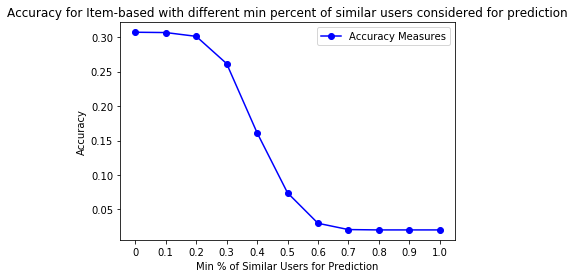

In [21]:
import matplotlib.pyplot as plt
thres = [0, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1.0]
#accuracy_list_item_k_selection = [0.9206820950105542, 0.9540010310965048, 0.9556928215357815, 0.9557781785880638, 0.95578248384213, 0.9557827009879355, 0.9557827119401965, 0.9557827124925989, 0.9557827125204607, 0.9557827125218663, 0.955782712521937]
xi = [i for i in range(0, len(thres))]
plt.plot(xi, accuracy_list_item_k_selection, label = 'Accuracy Measures', marker='o', c='b')
plt.xlabel('Min % of Similar Users for Prediction')
plt.ylabel('Accuracy')
plt.xticks(xi, thres)
plt.legend()
plt.title('Accuracy for Item-based with different min percent of similar users considered for prediction')
plt.show()